# Part 3: Hyperparameter Tuning

In Part 2, you likely "hardcoded" some numbers. For example, maybe you bought when sentiment was `> 0`, or you used a `20-day` moving average.
But are these the best values you could use?

## The Task
1.  Refactor your strategy into a function that accepts parameters (e.g., `def run_backtest(threshold, window)`).
2.  Run a Grid Search: Test every combination of two variables (e.g., Sentiment Threshold from 0.1 to 0.9 AND Stop Loss from 1% to 10%).
3.  Store the Total Return and Sharpe Ratio for each combination.
4.  Visualize the results using the provided **Heatmap** code to find the optimal parameter values.

If for some reason you cannot come up with 2 parameters to vary, you may use 1 but you must provide a brief justification as to why only one parameter is possible in a markdown cell below this.

We're going to vary the two parameters the system uses, in this case the lower bound of sentiment threshold and upper bound of sentiment threshold
as these are the only possible parameters that may vary in the system in its current implementation.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
prices = pd.read_csv("prices.csv", parse_dates=["date"])
market_news = pd.read_csv("market_news_sentiment.csv", parse_dates=["date"])

prices_long = prices.melt(id_vars=['date'], var_name='asset', value_name='adj_close')
df = pd.merge(prices_long, market_news[['date', 'asset', 'sentiment']], on=['date', 'asset'], how='left')
df['sentiment'] = df['sentiment'].fillna(0.0)

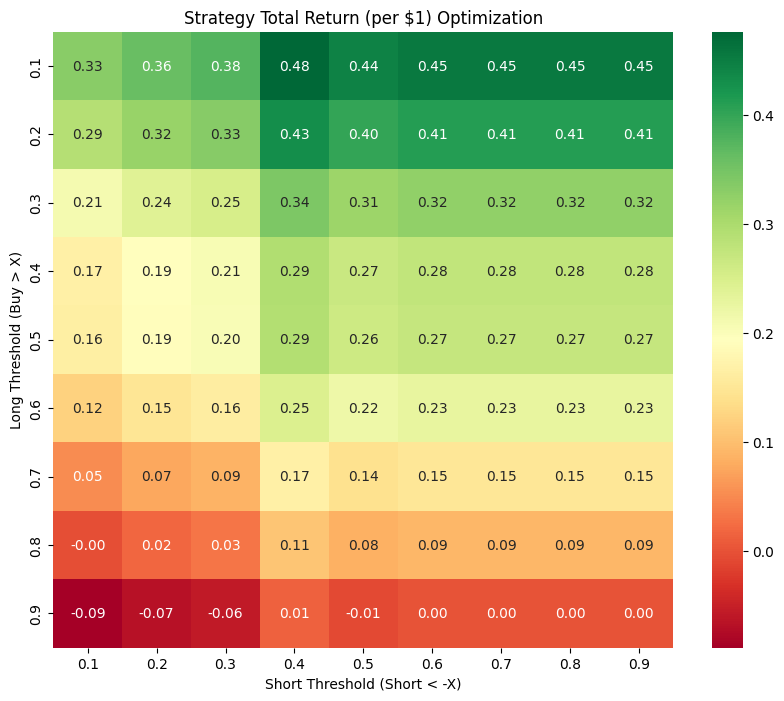

In [ ]:
def run_backtest(lst, sst):
    tdf = df.copy()

    def get_signal(score):
            if score > lst:
                return 1   # Long
            elif score < -sst:
                return -1  # Short
            else:
                return 0   # Hold
                
    tdf['raw_signal'] = tdf['sentiment'].apply(get_signal)

    # Avoid lookahead bias by shifting the signal by 1 day
    tdf['position'] = tdf.groupby('asset')['raw_signal'].shift(1)
    tdf['position'] = tdf['position'].fillna(0)

    # daily returns
    tdf['asset_return'] = tdf.groupby('asset')['adj_close'].pct_change() #group by asset to prevent shenanigans
    tdf['strategy_return'] = tdf['position'] * tdf['asset_return']

    # Take mean across all strategies
    portfolio_daily = tdf.groupby('date')['strategy_return'].mean()

    cumulative_return = (1 + portfolio_daily).cumprod()
    total_ret = cumulative_return.iloc[-1] - 1
    
    daily_std = portfolio_daily.std()
    
    sharpe = (0.0 if daily_std == 0 else (portfolio_daily.mean() / daily_std) * np.sqrt(252))
     
    return total_ret, sharpe
    
# run_backtest(0.5, 0.5)

thresholds = np.arange(0.1, 1.0, 0.1)
thresholds = [round(t, 1) for t in thresholds] # Weird float rounding

results = []
for long in thresholds:
    for short in thresholds:
        t_ret, sharpe = run_backtest(long, short)
        results.append({
            'Long_Threshold': long,
            'Short_Threshold': short,
            'Total_Return': t_ret,
            'Sharpe_Ratio': sharpe
        })

res = pd.DataFrame(results)


pivot_table = res.pivot(index='Long_Threshold', columns='Short_Threshold', values='Total_Return')

plt.figure(figsize=(10, 8))
# Use a Red-Yellow-Green colormap to visualize performance
sns.heatmap(pivot_table, annot=True, cmap='RdYlGn', fmt=".2f")

plt.title('Strategy Total Return (per $1) Optimization')
plt.ylabel('Long Threshold (Buy > X)')
plt.xlabel('Short Threshold (Short < -X)')
plt.show()
# BEST: 0.1 long , 0.4 short

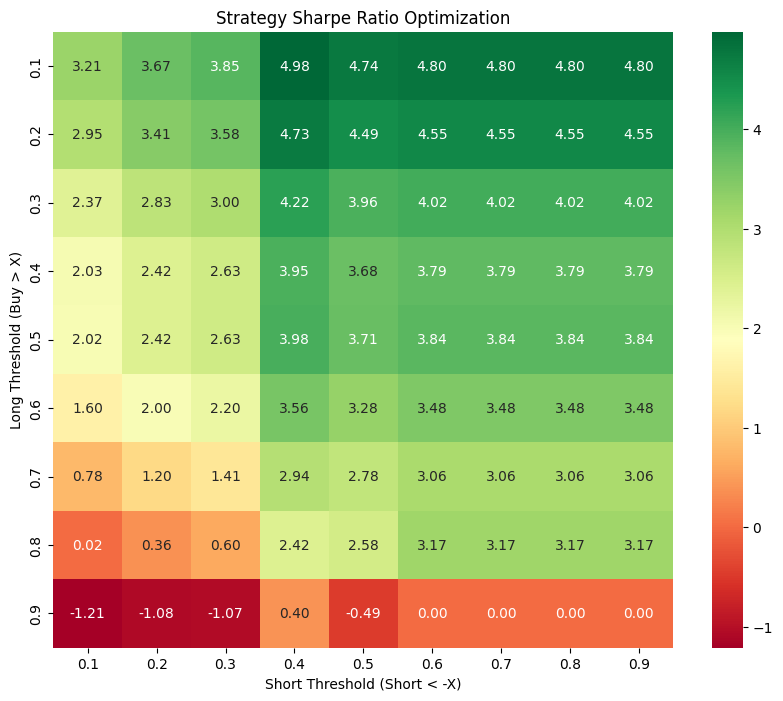

In [41]:
pivot_table = res.pivot(index='Long_Threshold', columns='Short_Threshold', values='Sharpe_Ratio')

plt.figure(figsize=(10, 8))
# Use a Red-Yellow-Green colormap to visualize performance
sns.heatmap(pivot_table, annot=True, cmap='RdYlGn', fmt=".2f")

plt.title('Strategy Sharpe Ratio Optimization')
plt.ylabel('Long Threshold (Buy > X)')
plt.xlabel('Short Threshold (Short < -X)')
plt.show()

## Calculate Performance Metrics
- Use the optimal (best resultant Sharpe Ratio) hyperparameters you have just found and re-run your backtest as in part 2. 
- Calculate and display the remaining performance metrics of your strategy (volatility, max drawdown, alpha, beta, etc.) - use SPY as your benchmark where necessary

In [ ]:
def get_signal(score):
    if score > 0.1:
        return 1 # Long
    elif score < -0.4:
        return -1 # Short
    else:
        return 0  # Hold

df['raw_signal'] = df['sentiment'].apply(get_signal)

# Avoid lookahead bias by shifting the signal by 1 day
df['position'] = df.groupby('asset')['raw_signal'].shift(1)
df['position'] = df['position'].fillna(0)

df['asset_return'] = df.groupby('asset')['adj_close'].pct_change() #group by asset to prevent shenanigans
df['strategy_return'] = df['position'] * df['asset_return']

# mean
portfolio = df.groupby('date')['strategy_return'].mean().to_frame('portfolio_return')
portfolio = portfolio.dropna()


TRADING_DAYS = 252

portfolio['cumulative_return'] = (1 + portfolio['portfolio_return']).cumprod()
total_return = portfolio['cumulative_return'].iloc[-1] - 1
volatility = portfolio['portfolio_return'].std() * np.sqrt(TRADING_DAYS)
sharpe_ratio = (portfolio['portfolio_return'].mean() / portfolio['portfolio_return'].std()) * np.sqrt(TRADING_DAYS)

cumulative = (1 + portfolio['portfolio_return']).cumprod()
running_max = cumulative.cummax()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min()

print("===== BACKTEST RESULTS =====")
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Volatility: {volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

===== BACKTEST RESULTS =====
Total Return: 47.60%
Annualized Volatility: 16.31%
Sharpe Ratio: 4.98
Max Drawdown: -4.33%


[*********************100%***********************]  1 of 1 completed


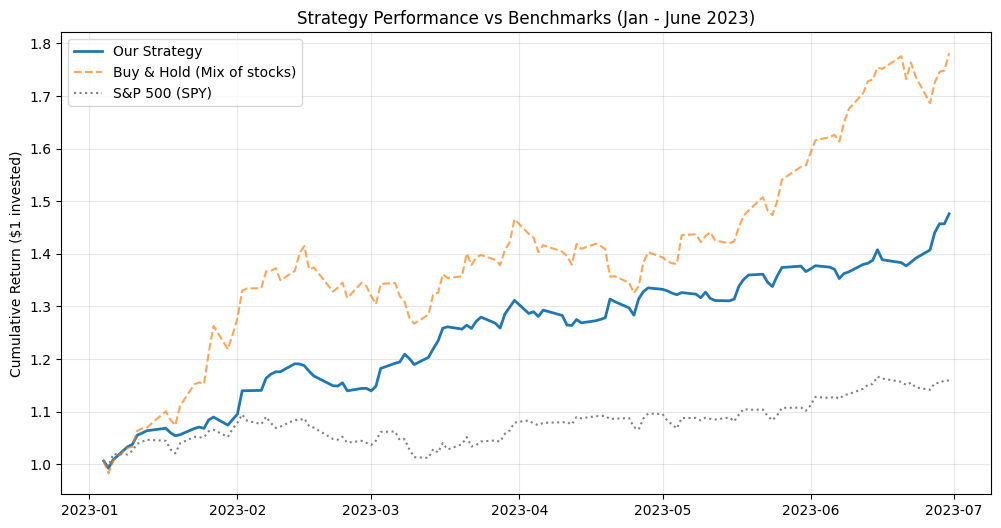

In [ ]:

bnh_returns = df.groupby('date')['asset_return'].mean().dropna()
bnh_cumulative = (1 + bnh_returns).cumprod()

# SPY
spy_data = yf.download(
    tickers="SPY",
    start="2023-01-01", # Use same timeframe
    end="2023-06-30",
    auto_adjust=True,
    progress=False
)['Close']

spy_returns = spy_data.pct_change().dropna()
spy_returns = spy_returns.reindex(portfolio.index).fillna(0)
spy_cumulative = (1 + spy_returns).cumprod()


plt.figure(figsize=(12, 6))
plt.plot(portfolio.index, portfolio['cumulative_return'], label='Our Strategy', linewidth=2)
plt.plot(bnh_cumulative.index, bnh_cumulative, label='Buy & Hold (Mix of stocks)', linestyle='--', alpha=0.7)
plt.plot(spy_cumulative.index, spy_cumulative, label='S&P 500 (SPY)', linestyle=':', color='gray')

plt.title('Strategy Performance vs Benchmarks (Jan - June 2023)')
plt.ylabel('Cumulative Return ($1 invested)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def calculate_metrics(strategy_rets, benchmark_rets, benchmark_name):
    # Align data
    aligned = pd.DataFrame({'strat': strategy_rets.squeeze(), 'bench': benchmark_rets.squeeze()}).dropna()
    
    # Excess Returns
    excess_returns = aligned['strat'] - aligned['bench']
    
    # Alpha & Beta (Linear Regression)
    # y = alpha + beta * x
    covariance = np.cov(aligned['strat'], aligned['bench'])[0, 1]
    variance = np.var(aligned['bench'])
    
    beta = covariance / variance
    
    # Jensen's Alpha = Mean_Strat - Beta * Mean_Bench
    alpha = (aligned['strat'].mean() - beta * aligned['bench'].mean()) * TRADING_DAYS
    
    # Information Ratio (Annualized)
    # IR = Mean(Excess) / Std(Excess)
    ir = (excess_returns.mean() / excess_returns.std()) * np.sqrt(TRADING_DAYS)
    
    print(f"--- vs {benchmark_name} ---")
    print(f"Alpha (Annualized): {alpha:.2%}")
    print(f"Beta: {beta:.2f}")
    print(f"Information Ratio: {ir:.2f}")
    print("")

    # print(aligned)

calculate_metrics(portfolio['portfolio_return'], bnh_returns, "Buy & Hold (Stock Mix)")
calculate_metrics(portfolio['portfolio_return'], spy_returns, "S&P 500 (SPY)")

--- vs Buy & Hold (Stock Mix) ---
Alpha (Annualized): 37.85%
Beta: 0.35
Information Ratio: -1.84

--- vs S&P 500 (SPY) ---
Alpha (Annualized): 60.03%
Beta: 0.68
Information Ratio: 3.58



(We note that these values are realistically subject to overfitting through the 6-month timespan, less likely to work as well on any other chosen 6-month sentiment/price combination)